# Red Giant Mode fitting

Fitting $nstars$ RG stars chosen at random using Vrard model.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import random

In [4]:
#import output data
nstars = 5
IDs = []
stardat = pd.read_csv('RGdata/output_1000stars.csv', delim_whitespace=False, header=0, usecols=range(1,4))
for i in range(nstars):
    IDs.append(random.choice(stardat['ID']))

modes = {} # dictionary with frequencies and errors
for i in IDs:
    modes[str(i)] = pd.read_csv('RGdata/modes_'+str(i)+'.csv', delim_whitespace=False, header=0, usecols=[0,7])
    modes[str(i)] = modes[str(i)].sort_values(by=['f0'])
    modes[str(i)] = modes[str(i)].set_index(np.arange(0,len(modes[str(i)]),1))
    modes[str(i)]['dnu'] = modes[str(i)].f0.diff(2).shift(-1)/2
    dnu_avg = np.mean(modes[str(i)].dnu)
    n_min = int(modes[str(i)].f0.min() / dnu_avg)
    n_obs = np.arange(n_min, n_min+len(modes[str(i)].f0), 1)
    modes[str(i)]['n'] = n_obs
    
stardat= stardat.loc[stardat['ID'].isin(IDs)]

To find a ballpark figure before defining priors, will use model:

$$\nu(n)=(n+\epsilon)\langle\Delta\nu\rangle+k(n_{max}-n)^2+\mathcal{A}e^{-n/\tau}sin(nw+\phi)$$

where $n_{max}= \nu_{max}/\Delta\nu - \epsilon$

In [5]:
def echelle(stardat, modes, ID, model=False, stanfit=[], stan_dnu=0):
    numax_obs = float(stardat.loc[stardat['ID'] == ID].Numax)
    numax_obs_err = float(stardat.loc[stardat['ID'] == ID].Numax_err)
    #dnu_obs = float(stardat.loc[stardat.ID == IDs[i]].Dnu_median_all)
    #dnu_obs = np.mean(np.diff(modes[str(IDs[i])].f0)) 
    dnu_obs = np.mean(modes[str(ID)].f0.diff(2).shift(-1)/2)
    # Create dataframes for frequencies and calculate orders n
    l0modes = pd.DataFrame([modes[str(ID)].f0, modes[str(ID)].f0_err])
    l0modes = l0modes.T
    l0modes = l0modes.sort_values('f0', ascending=True)
    n_min = int(l0modes.f0.min() / dnu_obs)
    n_obs = np.arange(n_min, n_min+len(l0modes.f0), 1)
    l0modes['n'] = n_obs
    l0modes = l0modes.set_index(np.arange(0, len(l0modes.f0), 1))
    plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = str(ID))
    
    if model:
        label = 'Stan Fit '+str(ID)
        plt.plot(stanfit % stan_dnu, stanfit, label = label)
        
    plt.xlabel(r'Frequency modulo ($\mu Hz$)')
    plt.ylabel(r'Frequency ($\mu Hz$)')
    plt.legend()

In [6]:
def model(n, dnu, nmax, epsilon, alpha, A, G, phi):
    freqs = (n + epsilon + alpha/2 * (nmax - n)**2 + A*G/(2*np.pi) * np.sin((2*np.pi*(n-nmax))/G + phi))*dnu #* np.exp(-n/tau);
    return freqs

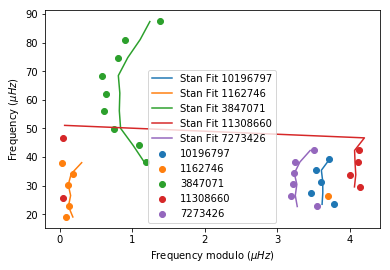

In [7]:
for i in IDs:
    #values from Vrard
    dnu_avg = np.mean(modes[str(i)].dnu)
    n = modes[str(i)].n
    #epsilon = 0.601 + 0.632*np.log(dnu_avg)
    epsilon = np.median((modes[str(i)].f0 % dnu_avg) / dnu_avg)
    numax_obs = float(stardat.loc[stardat['ID'] == i].Numax)
    nmax = numax_obs/dnu_avg - epsilon
    alpha = 0.015*dnu_avg**(-0.32)
    A = 0.06*dnu_avg**(-0.88) 
    G = 3.08
    #tau = 8
    phi = 1.71
    f = model(n, dnu_avg, nmax, epsilon, alpha, A, G, phi)
    echelle(stardat, modes, i, True, f, dnu_avg)
    

In [8]:
'''plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') 
plt.plot(f % dnu_obs, f, label = 'Model')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()'''

"plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') \nplt.plot(f % dnu_obs, f, label = 'Model')\nplt.xlabel(r'Frequency modulo ($\\mu Hz$)')\nplt.ylabel(r'Frequency ($\\mu Hz$)')\n#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)\nplt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')\nplt.legend()"

In [9]:
code = '''
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {
    real dnu;
    real nmax;
    real epsilon;
    real alpha;
    real<lower = 0> A;
    real<lower = 0> G;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    //real<lower = 0> tau;
    real epsA;
    real epsB;
    real alA;
    real alB;
    
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = (n[i] + epsilon + (alpha/2) * (nmax - n[i])^2 + 
            A*G/(2*pi()) * sin((2*pi()*(n[i]-nmax))/G + phi))*dnu;
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon ~ normal(epsA + epsB*log(dnu), 0.5);
    epsilon ~ uniform(-1.0, 2.0);
    nmax ~ normal(10, 4);
    alpha ~ lognormal(log(alA*dnu^(-alB)), 0.3);
    //alpha ~ lognormal(log(0.015*dnu^(-0.32)), 0.3);
    A ~ lognormal(log(0.06*dnu^(-0.88)), 0.4);
    G ~ normal(3.08, 0.65);
    // tau ~ normal(50, 10);
    epsA ~ normal(0.601, 0.080);
    epsB ~ normal(0.632, 0.080);
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
}
generated quantities{
    real fm[N];
    for (j in 1:N){
        fm[j] = (n[j] + epsilon + (alpha/2) * (nmax - n[j])^2 + 
            A*G/(2*pi()) * sin((2*pi()*(n[j]-nmax))/G + phi))*dnu;
        }
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc0ddc959414ab6fac6e16ba6472391d NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpsbsdl18q/stanfit4anon_model_cc0ddc959414ab6fac6e16ba6472391d_5559129757335362250.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [10]:
fits = {}
for i in IDs:
    dat_star = stardat.loc[stardat['ID'] == i]
    df_star = modes[str(i)]
    df_star = df_star.sort_values(by=['f0'])
    dnu_obs = np.mean(df_star.dnu)
    numax_obs = float(dat_star.loc[dat_star['ID'] == i].Numax)
    df_star = df_star.set_index(np.arange(0, len(df_star.f0), 1))
    nmax_guess = np.mean(df_star.n)
    epsilon_obs = np.median((df_star.f0 % dnu_obs) / dnu_obs)
    #epsilon_obs = 0.601 + 0.632*np.log(dnu_obs)
    alpha_obs = 0.015*dnu_obs**(-0.32)
    A_obs = 0.06*dnu_obs**(-0.88)
    
    data = {'N': len(df_star.f0), 'n': df_star.n.values, 'freq': df_star.f0.values,
            'freq_err': df_star.f0_err.values, 'dnu_guess': dnu_obs}
    start = {'dnu': dnu_obs, 'epsilon': epsilon_obs, 
             'nmax': numax_obs/dnu_obs - epsilon_obs, 'alpha': alpha_obs, 'A': A_obs,
             'G': 3, 'phi': 1.6}
    nchains=4
    fit = sm.sampling(data=data, iter=5000, chains=nchains, init=[start for n in range(nchains)])
    fits[str(i)] = fit
    output = pd.DataFrame({'dnu': fit['dnu'], 'nmax': fit['nmax'], 'epsilon': fit['epsilon'], 
                           'alpha': fit['alpha'], 'A': fit['A'], 'G': fit['G'], 'phi': fit['phi'], 
                           'epsA': fit['epsA'], 'epsB': fit['epsB'], 'alA': fit['alA'], 'alB': fit['alB']})
    #output.to_csv('samples_' + str(i) + '.csv')

In [11]:
for i in IDs:
    print('ID = ' + str(i))
    print(fits[str(i)])

ID = 10196797
Inference for Stan model: anon_model_cc0ddc959414ab6fac6e16ba6472391d.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.97  5.2e-5 4.0e-3   3.96   3.97   3.97   3.97   3.98   5804    1.0
nmax      6.93  2.6e-3   0.17   6.58   6.82   6.93   7.04   7.27   4281    1.0
epsilon   0.89  1.2e-4 8.8e-3   0.87   0.88   0.89    0.9   0.91   5561    1.0
alpha     0.02  6.4e-5 4.9e-3 9.1e-3   0.01   0.02   0.02   0.03   5774    1.0
A         0.05  1.2e-4   0.01   0.03   0.04   0.05   0.06   0.07   8587    1.0
G         2.36  3.1e-3   0.22    1.9   2.23   2.36    2.5    2.8   4990    1.0
phi       0.95  9.1e-3   0.55  -0.12   0.61   0.95   1.27    2.1   3709    1.0
epsA      0.59  7.8e-4   0.08   0.43   0.53   0.59   0.64   0.74  10180    1.0
epsB      0.61  7.6e-4   0.08   0.46   0.56   0.61   0.67   0.77  10579    1.0
alA   

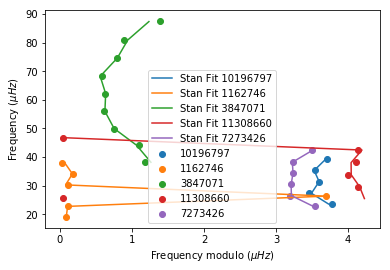

In [12]:
for i in IDs:
    stanfit = model(modes[str(i)].n, fits[str(i)]['dnu'].mean(), fits[str(i)]['nmax'].mean(), fits[str(i)]['epsilon'].mean(), fits[str(i)]['alpha'].mean(), fits[str(i)]['A'].mean(), fits[str(i)]['G'].mean(), fits[str(i)]['phi'].mean())
    stan_dnu = fits[str(i)]['dnu'].mean()
    echelle(stardat, modes, i, True, stanfit, stan_dnu)

In [ ]:
import corner
data = np.vstack([fit['dnu'], fit['nmax'], fit['epsilon'], fit['alpha'], fit['A'], fit['G'], fit['phi'], 
                fit['epsA'], fit['epsB'], fit['alA'], fit['alB'], fit['AA'], fit['AB']]).T
corner.corner(data, labels=['dnu', 'nmax', 'epsilon', 'alpha', 'A', 'G', 'phi', 'epsA', 'epsB', 'alA', 'alB', 'AA', 'AB'])
plt.show()